# basic set up

In [1]:
#basic set up
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd


#netflow 
import ets_fiber_assigner.netflow as nf
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict

# key functions

In [2]:

# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 150,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P3"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 80,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}

    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 240,
                        "nonObservationCost": 1e6, "calib": True}
    classdict["cal"] = {"numRequired": 40,
                        "nonObservationCost": 1e6, "calib": True}

    return classdict

# TODO-0: plot the distribution of the cosmology, star, and sky
# TODO-1: make posang and otime as input parameters
# TODO-2: test different otime outputs of tpos
# TODO-3: make Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage=False):
    '''
    Parameters
    ==========
    two_stage (boolean): whether to do two stage assignment or not
    
    Returns
    =======
    '''
    # get a complete, idealized focal plane configuration
    bench = Bench(layout="full")
    # if you have the XML file, you can also generate a more realistic focal plane
    # bench = Bench(calibrationProduct=CobrasCalibrationProduct(
    #     "../ics_cobraOps/python/ics/demos/updatedMaps6.xml"))

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = 0.
    otime = "2016-04-03T08:00:00Z"
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    vis_cost = [0.1*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        return 0.01*dist

    #refer to gurobi website for information on these parameters, LogToConsole=1 will display the running process
    gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0,
                         heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs)

        prob0.solve()
        Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    #clear_output()
    
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    
    return res, tpos, telescopes


def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out


def collision_sim(res, tpos):
    '''collision simulation
    Parameters
    ==========
    res: dict
        resolution for each visit
    tpos: dict
        telescope position (pointing center of each visit)
    '''
    for vis, tp in zip(res, tpos):
        selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
        ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
        for tidx, cidx in vis.items():
            selectedTargets[cidx] = tp[tidx]
            ids[cidx] = ""
        for i in range(selectedTargets.size):
            if selectedTargets[i] != NULL_TARGET_POSITION:
                dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

        simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
        simulator.run()
        simulator.plotResults(paintFootprints=False)
        plotUtils.pauseExecution()

        # Animate the trajectory collisions
        (problematicCobras,) = np.where(np.logical_and(
            simulator.collisions, ~simulator.endPointCollisions))
        for cbr in problematicCobras:
            simulator.animateCobraTrajectory(cbr)
            plotUtils.pauseExecution()

        '''
        ets_fiber_assigner.io_helpers.writePfsDesign(
            pfsDesignId=i,
            pfsDesignDirectory='.',
            vis=vis,
            tp=tp,
            tel=tel,
            tgt=tgt,
            classdict=tclassdict)
        '''

## plot_filter_fov function

In [3]:

# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

## check_output function

In [ ]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors

'''
def check_output(xsclae):
    for reg_i, peak_i in enumerate(peaks_used):
        # read the first visit output file
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt('./output/s21a_sel_test/regcut/'+'hsc_s21a_output_v1_regcut%d_%.3f.txt'%(reg_i, xscale), usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        #plot the done samples
        plt.plot(tgt_ra_done, tgt_dec_done, 'b.', ms=0.2, alpha=0.5)

        # read the second visit output file
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt('./output/s21a_sel_test/regcut/'+'hsc_s21a_output_v2_regcut%d_%.3f.txt'%(reg_i, xscale), usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        #plot the done samples
        plt.plot(tgt_ra_done, tgt_dec_done, 'r.', ms=0.2, alpha=0.5)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig('./output/s21a_sel_test/regcut/HSC_s21a_Output_%.3f.png'%xscale)
    plt.show()
    plt.close()
    
check_output(xscale)
'''

# main function

construct target list:
../data_proc/test/cosmology_region3_3h_targets.ecsv
../data_proc/test/star_region3_3h_targets.ecsv
../data_proc/test/sky_region3_3h_targets.ecsv
In total, there are 1658996 targets.
Time passed - construct target list: 35.61 secs
There are 16 pointings.
  Your sample (gray), with the pointings (red):


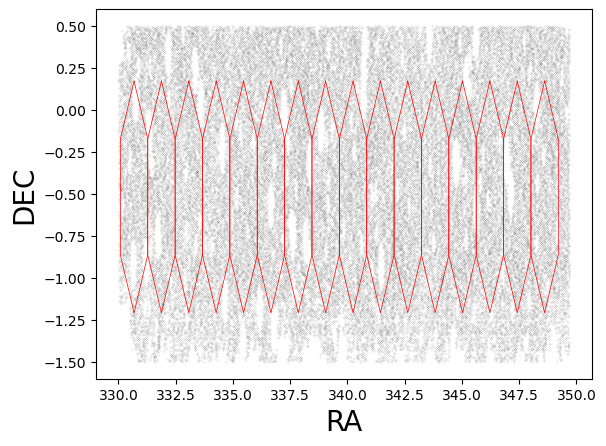

Time passed - read pointings and plot for a small region: 1.05 secs


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2379863
Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 263429 rows, 128955 columns and 659694 nonzeros
Model fingerprint: 0x384a55a0
Variable types: 1 continuous, 128954 integer (114622 binary)
Coefficient statistics:


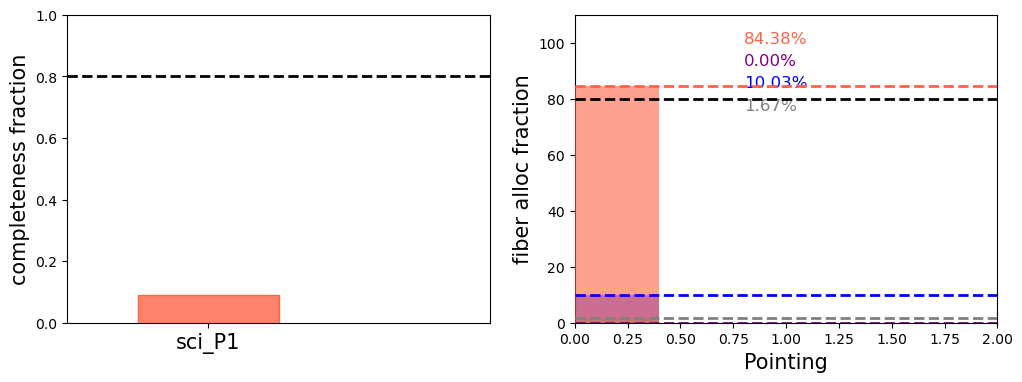

        cal    sci_P1       sky
0  0.056338  0.090762  0.004919
comp_out_tmp1 =  {'cal': 0.056338028169014086, 'sci_P1': 0.09076204169662114, 'sky': 0.004918738343614863}
solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 254344 rows, 128046 columns and 639087 nonzeros
Model fingerprint: 0xcd6895aa
Variable types: 1 continuous, 128045 integer (113423 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 2.829238e+08
Presolve removed 253598 rows and 125047 columns
Presolve time: 1.24s
Presolved: 746 rows, 2999 columns, 4522 nonzeros
Found heuristic solution: objective 2.804969e+08
Variable types: 0 continuous, 2999 integ

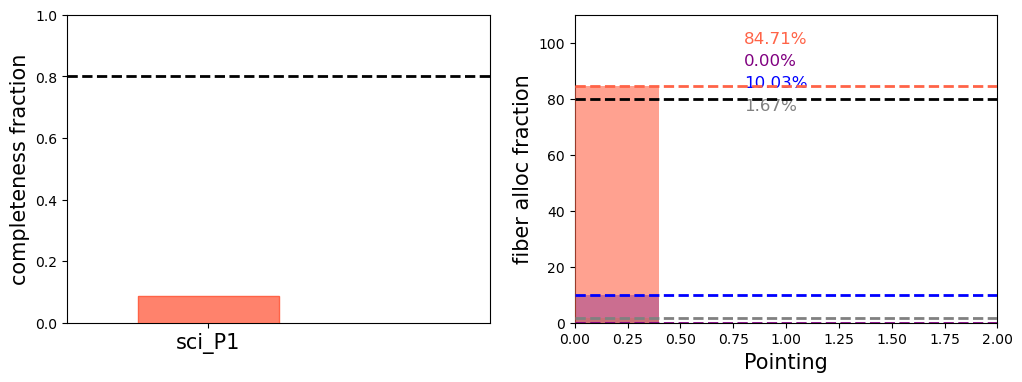

        cal    sci_P1       sky
0  0.076482  0.085181  0.004901
comp_out_tmp1 =  {'cal': 0.07648183556405354, 'sci_P1': 0.08518145161290322, 'sky': 0.004901460226692535}
solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 274386 rows, 136244 columns and 688586 nonzeros
Model fingerprint: 0xa1bdc546
Variable types: 1 continuous, 136243 integer (121113 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.830254e+08
Presolve removed 273655 rows and 133148 columns
Presolve time: 1.56s
Presolved: 731 rows, 3096 columns, 4585 nonzeros
Found heuristic solution: objective 2.805687e+08
Variable types: 0 continuous, 3096 integ

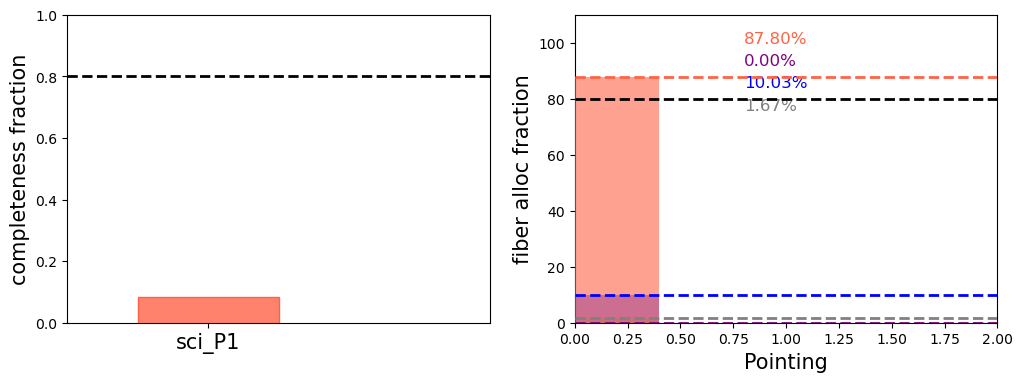

        cal    sci_P1       sky
0  0.080808  0.084967  0.004617
comp_out_tmp1 =  {'cal': 0.08080808080808081, 'sci_P1': 0.08496705606532196, 'sky': 0.004616538750072134}
solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 272464 rows, 132930 columns and 682363 nonzeros
Model fingerprint: 0xfb6910bf
Variable types: 1 continuous, 132929 integer (118515 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 2.828822e+08
Presolve removed 271765 rows and 129914 columns
Presolve time: 1.33s
Presolved: 699 rows, 3016 columns, 4427 nonzeros
Found heuristic solution: objective 2.804397e+08
Variable types: 0 continuous, 3016 integ

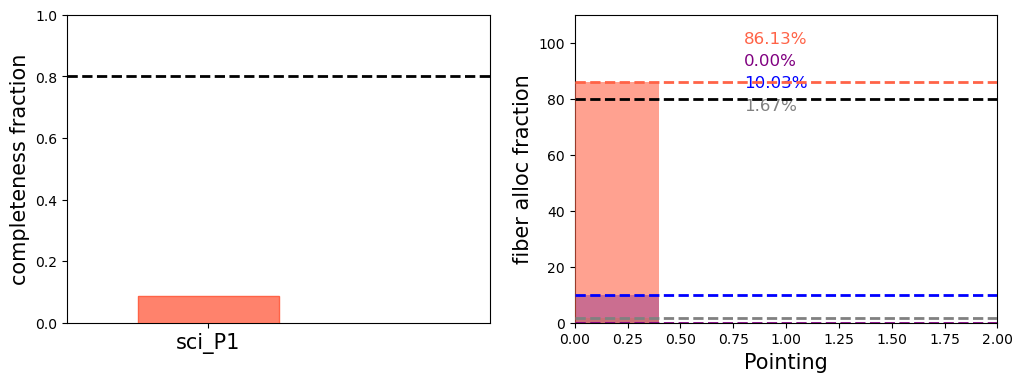

        cal   sci_P1       sky
0  0.087146  0.08724  0.004687
comp_out_tmp1 =  {'cal': 0.08714596949891068, 'sci_P1': 0.08723980368928752, 'sky': 0.004687042281027244}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 291962 rows, 142104 columns and 729878 nonzeros
Model fingerprint: 0x688d8015
Variable types: 1 continuous, 142103 integer (125937 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

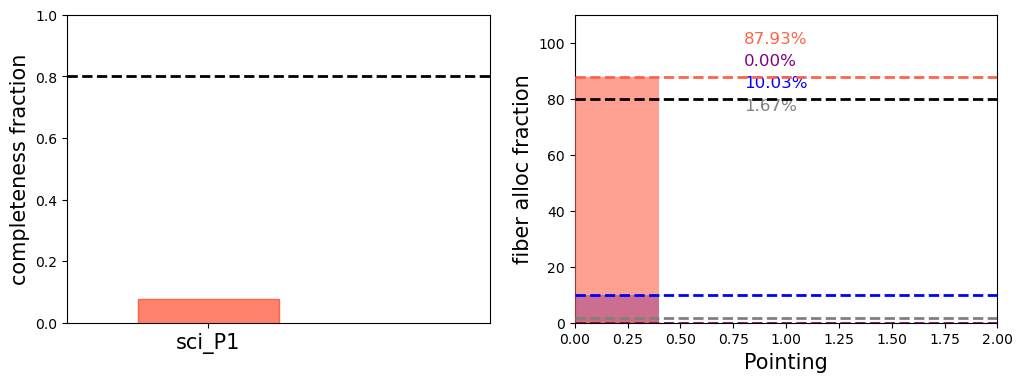

        cal    sci_P1       sky
0  0.083682  0.077373  0.004478
comp_out_tmp1 =  {'cal': 0.08368200836820083, 'sci_P1': 0.07737263838859075, 'sky': 0.0044782803403493054}
solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 295632 rows, 141783 columns and 738426 nonzeros
Model fingerprint: 0xbc6631e0
Variable types: 1 continuous, 141782 integer (125671 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.832216e+08
Presolve removed 294686 rows and 138499 columns
Presolve time: 1.55s
Presolved: 946 rows, 3284 columns, 5205 nonzeros
Found heuristic solution: objective 2.807791e+08
Variable types: 0 continuous, 3284 integ

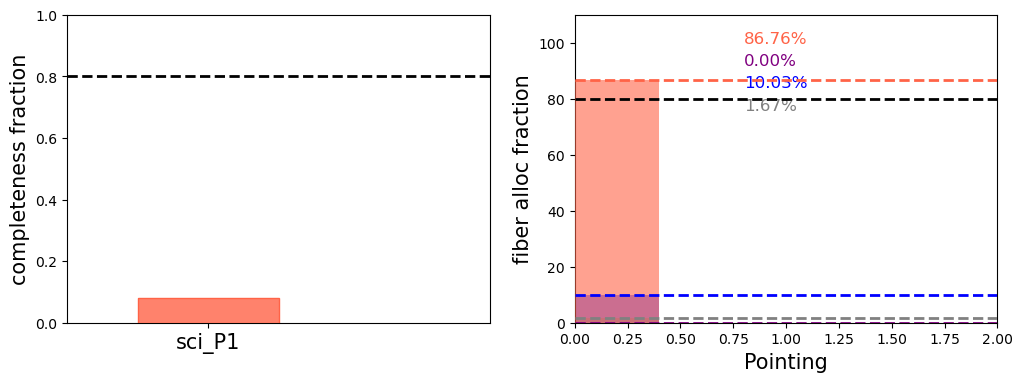

       cal    sci_P1       sky
0  0.06006  0.080137  0.004617
comp_out_tmp1 =  {'cal': 0.06006006006006006, 'sci_P1': 0.08013735627749055, 'sky': 0.0046168051708217915}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 272366 rows, 130812 columns and 679680 nonzeros
Model fingerprint: 0xbc769e9f
Variable types: 1 continuous, 130811 integer (116247 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 2.82

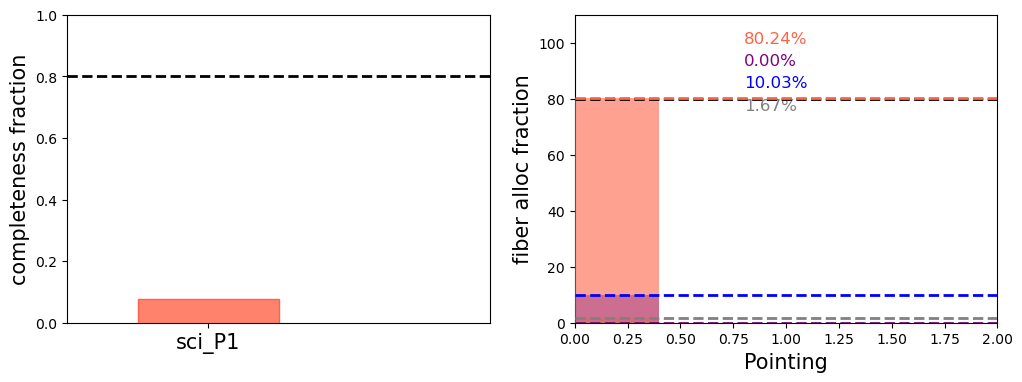

        cal    sci_P1       sky
0  0.065253  0.076143  0.004702
comp_out_tmp1 =  {'cal': 0.06525285481239804, 'sci_P1': 0.0761425343850331, 'sky': 0.004701917990713712}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 289469 rows, 138533 columns and 722550 nonzeros
Model fingerprint: 0xf12af2a8
Variable types: 1 continuous, 138532 integer (123128 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

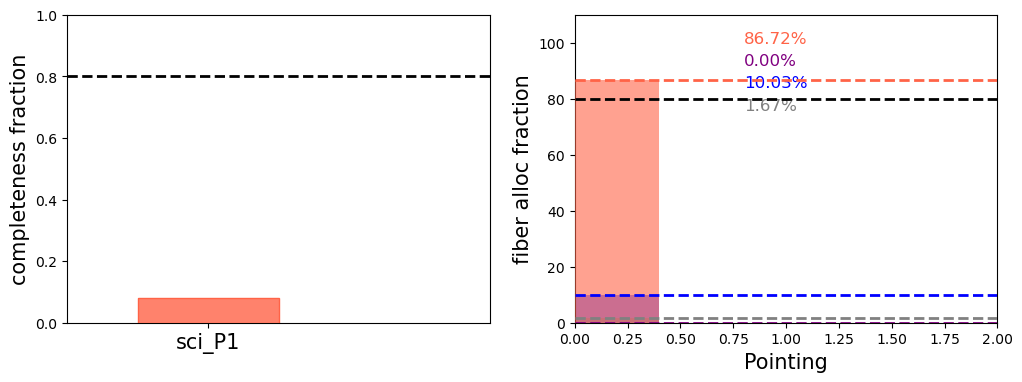

        cal    sci_P1       sky
0  0.061824  0.079249  0.004502
comp_out_tmp1 =  {'cal': 0.061823802163833076, 'sci_P1': 0.07924874026568941, 'sky': 0.004501885164412598}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 304732 rows, 146172 columns and 759556 nonzeros
Model fingerprint: 0x7a01723e
Variable types: 1 continuous, 146171 integer (129464 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

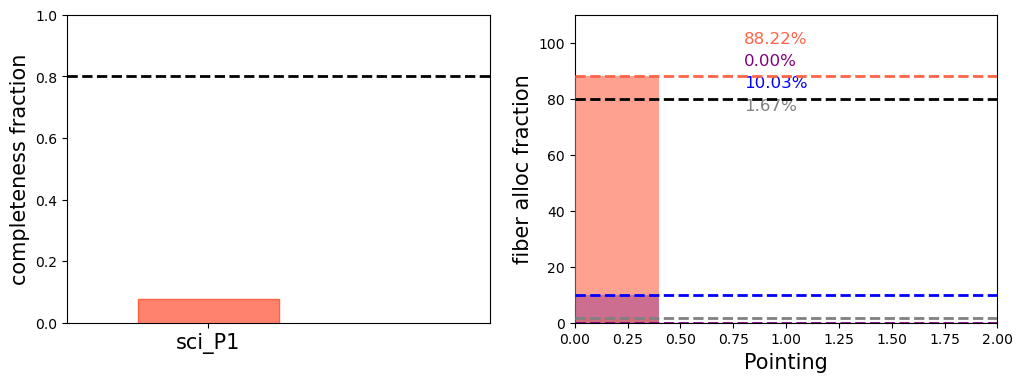

        cal    sci_P1       sky
0  0.060514  0.077179  0.004436
comp_out_tmp1 =  {'cal': 0.060514372163388806, 'sci_P1': 0.07717887812899689, 'sky': 0.004436311207231187}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 303500 rows, 144397 columns and 756486 nonzeros
Model fingerprint: 0xbdb195df
Variable types: 1 continuous, 144396 integer (127953 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

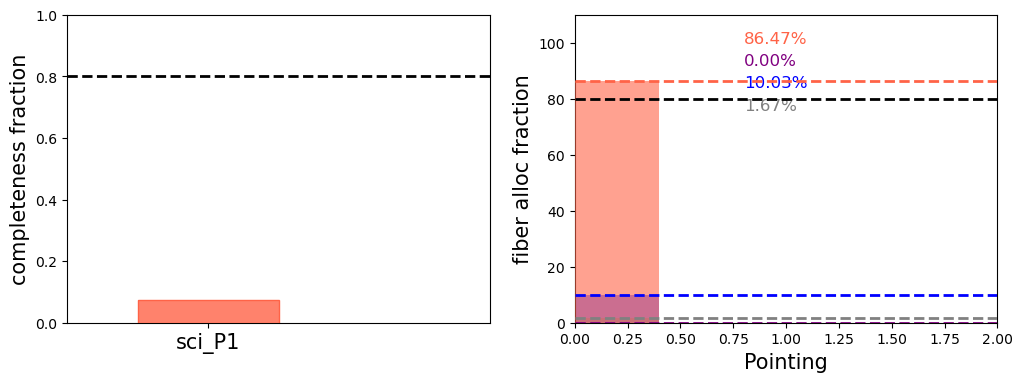

        cal    sci_P1       sky
0  0.071813  0.074525  0.004392
comp_out_tmp1 =  {'cal': 0.0718132854578097, 'sci_P1': 0.07452476958525346, 'sky': 0.004392065002562038}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 305873 rows, 146570 columns and 763181 nonzeros
Model fingerprint: 0x6ecb7977
Variable types: 1 continuous, 146569 integer (129831 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

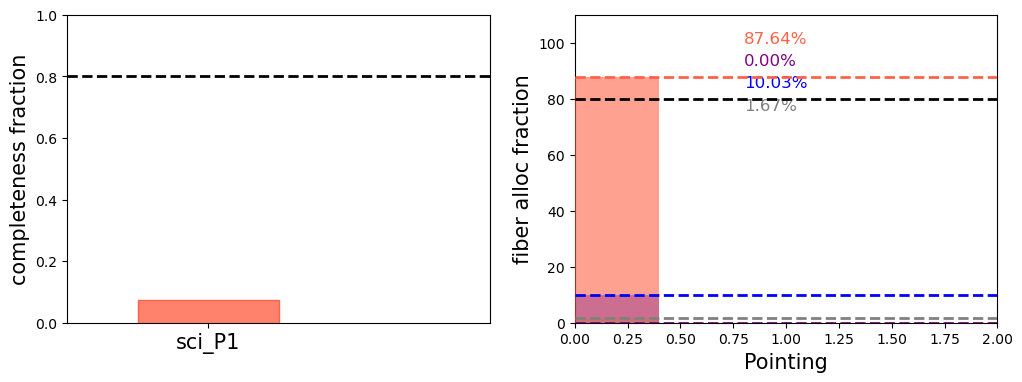

       cal    sci_P1       sky
0  0.10989  0.074442  0.004329
comp_out_tmp1 =  {'cal': 0.10989010989010989, 'sci_P1': 0.07444203952737466, 'sky': 0.004328926245919085}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 309367 rows, 147415 columns and 771629 nonzeros
Model fingerprint: 0xdb0ca1e6
Variable types: 1 continuous, 147414 integer (131184 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

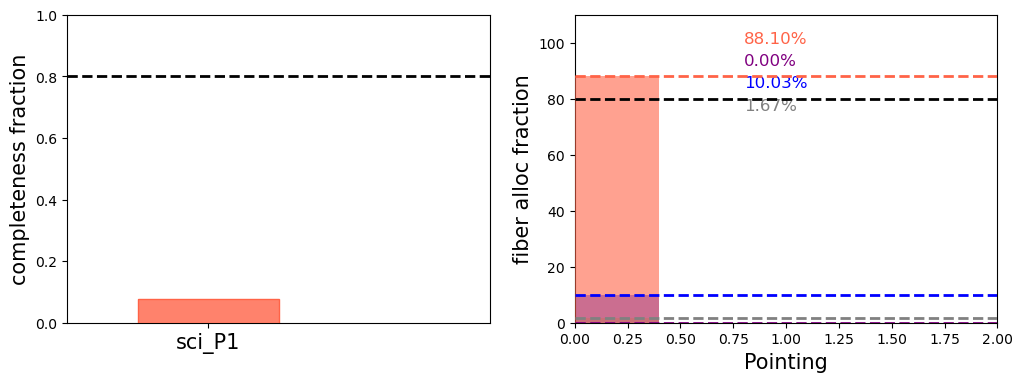

        cal    sci_P1       sky
0  0.103359  0.077284  0.004212
comp_out_tmp1 =  {'cal': 0.10335917312661498, 'sci_P1': 0.07728388728058924, 'sky': 0.004211708549768356}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 298273 rows, 142032 columns and 743444 nonzeros
Model fingerprint: 0x17fc8b33
Variable types: 1 continuous, 142031 integer (125670 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

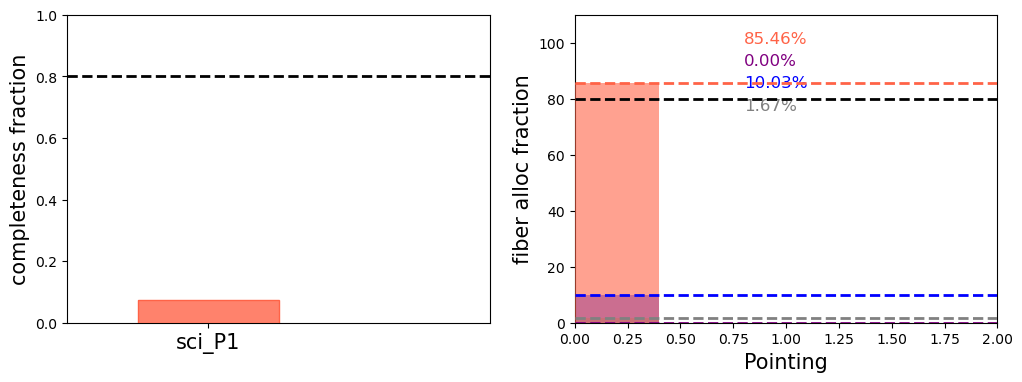

        cal    sci_P1      sky
0  0.081136  0.075304  0.00447
comp_out_tmp1 =  {'cal': 0.08113590263691683, 'sci_P1': 0.07530364372469636, 'sky': 0.004470022908867408}
solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 310072 rows, 145824 columns and 771025 nonzeros
Model fingerprint: 0xc9b617d2
Variable types: 1 continuous, 145823 integer (129548 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.832544e+08
Presolve removed 309289 rows and 142678 columns
Presolve time: 1.61s
Presolved: 783 rows, 3146 columns, 4724 nonzeros
Found heuristic solution: objective 2.808043e+08
Variable types: 0 continuous, 3146 integ

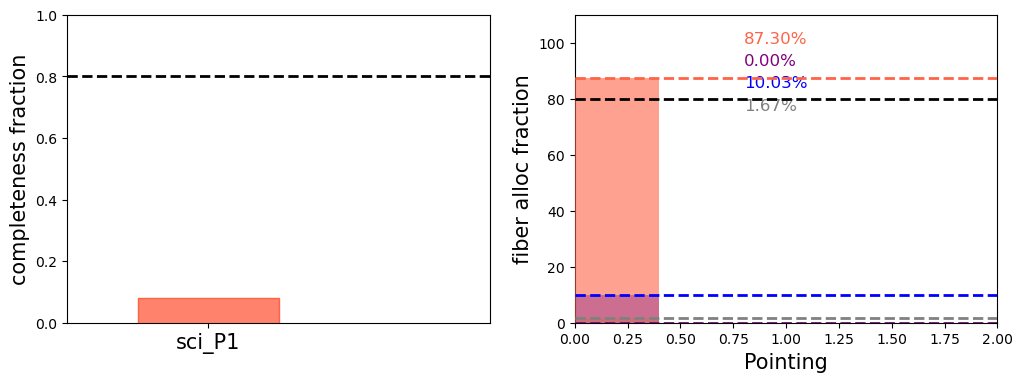

        cal   sci_P1      sky
0  0.088692  0.07882  0.00433
comp_out_tmp1 =  {'cal': 0.08869179600886919, 'sci_P1': 0.07882033489214059, 'sky': 0.0043302540415704385}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 305229 rows, 144733 columns and 760215 nonzeros
Model fingerprint: 0x46fa3d6a
Variable types: 1 continuous, 144732 integer (128262 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

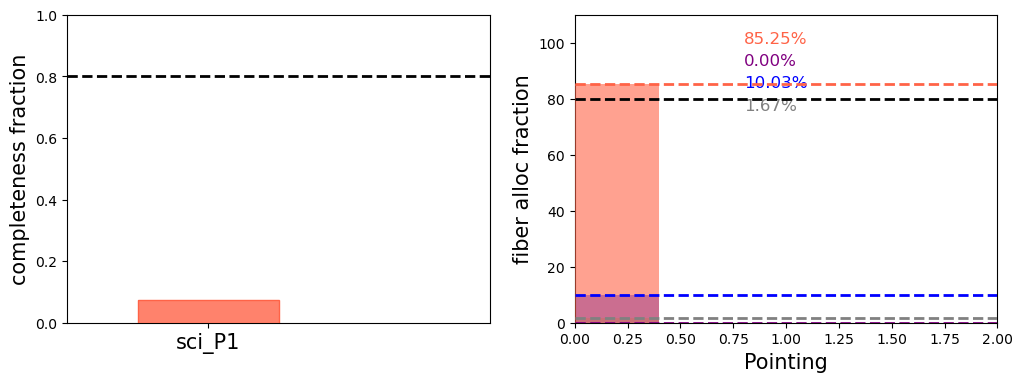

        cal    sci_P1       sky
0  0.070299  0.074359  0.004342
comp_out_tmp1 =  {'cal': 0.070298769771529, 'sci_P1': 0.07435878752550276, 'sky': 0.004342083838402113}


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solving the problem for stage=0 targets.
Set parameter Presolve to value 1
Set parameter Method to value 4
Set parameter DegenMoves to value 0
Set parameter Heuristics to value 0.8
Set parameter MIPGap to value 0.05
Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp
Optimize a model with 313199 rows, 148235 columns and 779902 nonzeros
Model fingerprint: 0x8243e8b2
Variable types: 1 continuous, 148234 integer (131481 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2.83

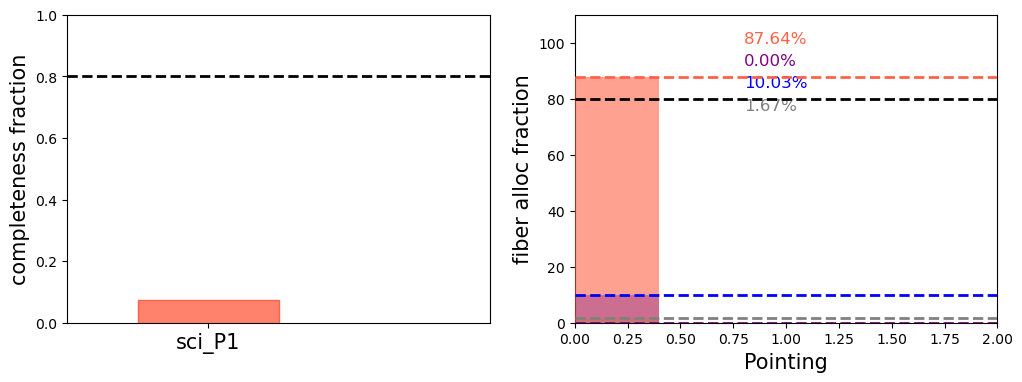

        cal    sci_P1      sky
0  0.069565  0.075073  0.00429
comp_out_tmp1 =  {'cal': 0.06956521739130435, 'sci_P1': 0.07507335575753238, 'sky': 0.00429046444277593}
530.128167 secs passed after the visits done.


In [4]:
if __name__ == "__main__":
    # TODO: revise the two-stage code structure
    two_stage = True
    outdir = "../output/test/"
    
    t0 = time.time()
    ########################
    #cosmology + sky + star targets
    fn_list = ["cosmology_region3_3h_targets.ecsv", "star_region3_3h_targets.ecsv", "sky_region3_3h_targets.ecsv"]
    prefix_list = ["sci", "cal", "sky"]
    calibration_list = [False, True, True]
    
    tgt_s0, sample_sci = construct_tgt_list(catalog_path = "../data_proc/test/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
    '''
    # TODO: prepare ancillary science targets (smaller size sample)
    #anxillary science targets
    fn_list = ["anc_select.ecsv", ]
    prefix_list = ["anc", ]
    calibration_list = [False, ]
    
    tgt_s1, sample_sci_s1 = construct_tgt_list(catalog_path = "../data_proc/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    '''

    #total targets
    #tgt = tgt_s0 + tgt_s1
    tgt = tgt_s0
    
    n_sci = sample_sci.shape[0]
    ra_sci = sample_sci[:, 1].astype('float')
    dec_sci = sample_sci[:, 2].astype('float')

    t1 = time.time()
    print("Time passed - construct target list: %.2f secs" % (t1-t0))

    #set the range for getting pointing centers
    ra_min, ra_max, dec_min, dec_max = 330, 349, -1.5, 0.5

    # read the pointing centers from the file
    ra_peaks, dec_peaks = read_pointings("../output/cosmology_region3_pointings.txt")

    # select peaks within the range
    mask_peaks = (ra_peaks>ra_min) & (ra_peaks<ra_max) & (dec_peaks>dec_min) & (dec_peaks<dec_max)
    peaks = np.array([ra_peaks[mask_peaks], dec_peaks[mask_peaks]]).T
    npoint = peaks.shape[0]
    print("There are %d pointings." % npoint)
    
    # plot the pointing and samples
    print("  Your sample (gray), with the pointings (red):")
    fov_diag = 1.38/2. # deg, here it's radius
    mask_sci = (ra_sci>ra_min-fov_diag) & (ra_sci<ra_max+fov_diag) & (dec_sci>dec_min-fov_diag) & (dec_sci<dec_max+fov_diag)
    plt.plot(ra_sci[mask_sci][::10], dec_sci[mask_sci][::10], 'k.', ms=0.2, alpha=0.5)

    for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
        flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci[mask_sci], dec_sci[mask_sci], PA=0, n_sci_fov_least=4000, filter_fov=True)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig('../output/figures/cosmology_region3_test_fov_plot.png')
    plt.show()
    plt.close()
    
    t2 = time.time()
    print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))
    
    
    ########################
    classdict = def_classdict()

    ########################
    # one visit -- can be 1st or 2nd visit
    # TODO: set the alreadyObserved dictionary using the alreadyObserved column in the target list
    alreadyObserved={}
    for t in tgt:
        alreadyObserved[t.ID] = 0
    
    '''
    #Here use stage instead of preassigned parameter
    '''
    for peak in peaks:
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()

        # TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, two_stage=two_stage)
        write_output(tgt_peak, res, tpos, telescopes, outdir, 'cosmology_region3_3h_output_v1_ra%.2f_dec%.2f.txt'%(peak[0], peak[1]))
        
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+'cosmology_region3_3h_v1_ra%.2f_dec%.2f.jpg'%(peak[0], peak[1]), Save=True, fn_fibeff=outdir+'cosmology_region3_3h_fibeff_v1.txt')
        
        #with open(outdir + 'cosmology_region3_v1.pkl', 'wb') as fp:
        #    pickle.dump(comp_out_tmp1, fp)
        # Convert scalar values to lists
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + 'cosmology_region3_3h_v1_ra%.2f_dec%.2f.csv'%(peak[0], peak[1]), index=False)

        print(df)
        print("comp_out_tmp1 = ", comp_out_tmp1)

    print("%f secs passed after the visits done." % (time.time()-t0))

    '''
    #second visit
    # read the first visit output file
    tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(out_dirbase+'stage_hsc_s21a_output_v1_%.3f.txt'%xscale, usecols=(0, 4, 5), unpack=True, dtype='str')
    tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

    alreadyObserved={}
    for t in tgt:
        alreadyObserved[t.ID] = 0
    for t in tgt_id_done:
        alreadyObserved[str(t)] = 1
    '''
    
    

# test otime outputs of tpos

In [5]:
raTel, decTel = peaks[:, 0], peaks[:, 1]
posang = 0.
otime = "2025-01-25T12:00:00Z" #Here is UTC time; UTC-10 is Hawaii time zone
telescopes = []

# number of distinct observations
nvisit = len(raTel)

# generate telescope pointings for every observation
for ii in range(nvisit)[:1]:
    telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

# get focal plane positions for all targets and all visits
tpos = [tele.get_fp_positions(tgt) for tele in telescopes]

print("otime=", otime, "tpos[0][0]=", tpos[0][0])

/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


otime= 2025-01-25T12:00:00Z tpos[0][0]= (-336.6723372593129-92.25070027968124j)


+ otime= 2025-01-22T12:00:00Z tpos[0][0]= (-336.59320248092837-92.19493253559092j)
+ otime= 2025-01-25T12:00:00Z tpos[0][0]= (-336.61438595249626-92.22338877268048j)
+ otime= 2025-01-22T15:00:00Z tpos[0][0]= (-336.81141273127696-92.7063050579829j)
+ otime= 2025-01-27T12:00:00Z tpos[0][0]= (-336.6303519582735-92.24831859510454j)

# TO-DO Lists
+ make the assignment faster by feeding each pointing a smaller region targets (for each task, in the case of parallel running)
+ update the target list after each observation
+ second visit, pointing center shift to avoid vignetting 
+ longer exposure option for second visit
